In [1]:
from scipy.optimize import curve_fit
from qubit_zz_coupling.utils import exp_decay, ramsey, make_population


In [6]:
import numpy as np
import qutip as qt

# Qubit parameters
w_q = 2*np.pi * 1.0    # qubit frequency (GHz, say)
omega = 2*np.pi * 0.05 # drive amplitude (sets π/2 duration)
T1, T2 = 1e3, 1e3      # decoherence times

sx = qt.sigmax()
sz = qt.sigmaz()

sm = np.sqrt(1/T1) * qt.sigmam()

opts = qt.Options(nsteps=1000000)

# Bare Hamiltonian
H0 = 0.5 * w_q * sz

# Build propagator for one H(t) = H0 + Ω cos(ω_d t) σx pulse
def pulse_propagator(w_d, omega, t_pulse):
    H = [
        H0,
        [sx, lambda t, args: 2 * omega * np.cos(w_d * t)]
    ]
    return qt.propagator(H, t_pulse)

# Ramsey expectation value
def ramsey_expectation(tau, w_d1, w_d2, t_pulse):
    U1     = pulse_propagator(w_d1, omega, t_pulse)   # first π/2 at ω_d1
    U_free = qt.propagator(H0, tau, options=opts)     # free evolution
    U2     = pulse_propagator(w_d2, omega, t_pulse)   # second π/2 at ω_d2
    U_tot  = U2 * U_free * U1
    psi0   = qt.basis(2,0)
    psif   = U_tot * psi0
    return qt.expect(sz, psif)

# Example sweep
taus      = np.linspace(0, 200, 201)
detunings = np.linspace(-0.2, +0.2, 5) * 2*np.pi
t_p = np.pi/(2*omega)

data = {}
for delta in detunings:
    w_d1 = w_q + delta
    vals = [ramsey_expectation(tau, w_d1, w_q, t_p) for tau in taus]
    data[delta] = vals

/home/jayamao/miniforge3/envs/qiskit/lib/python3.10/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


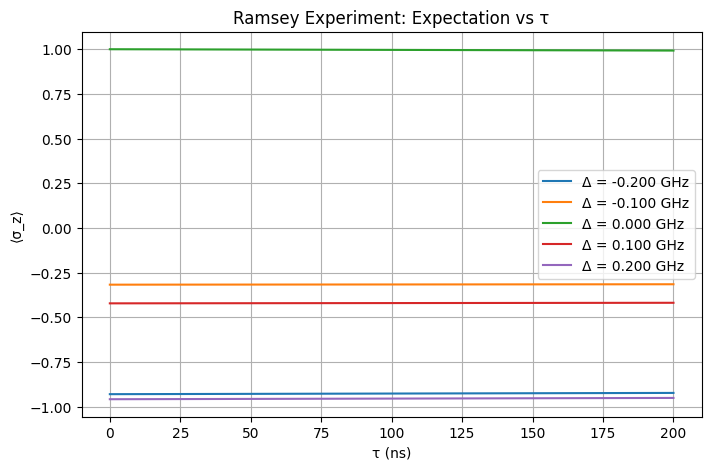

In [7]:
# ...existing code...

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for delta, vals in data.items():
    plt.plot(taus, vals, label=f"Δ = {delta/(2*np.pi):.3f} GHz")
plt.xlabel("τ (ns)")
plt.ylabel("⟨σ_z⟩")
plt.title("Ramsey Experiment: Expectation vs τ")
plt.legend()
plt.grid(True)
plt.show()
# ...existing code...

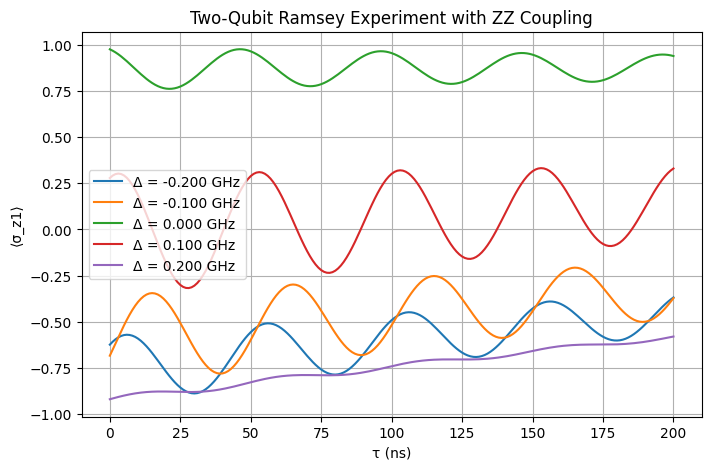

In [12]:
import numpy as np
import qutip as qt

# Two-qubit parameters
w_q1 = 2 * np.pi * 1.0    # Qubit 1 frequency (GHz)
w_q2 = 2 * np.pi * 1.1    # Qubit 2 frequency (GHz)
omega1 = 2 * np.pi * 0.05 # Qubit 1 drive amplitude
omega2 = 2 * np.pi * 0.05 # Qubit 2 drive amplitude
T1, T2 = 1e3, 1e3         # decoherence times
Jz = 2 * np.pi * 0.01     # ZZ coupling strength

# Operators
I = qt.qeye(2)
sx1 = qt.tensor(qt.sigmax(), I)
sx2 = qt.tensor(I, qt.sigmax())
sz1 = qt.tensor(qt.sigmaz(), I)
sz2 = qt.tensor(I, qt.sigmaz())
sm1 = qt.tensor(qt.sigmam(), I)
sm2 = qt.tensor(I, qt.sigmam())

opts = qt.Options(nsteps=1000000)

# Bare Hamiltonian with ZZ coupling
H0 = 0.5 * w_q1 * sz1 + 0.5 * w_q2 * sz2 + Jz * sz1 * sz2

# Build propagator for one H(t) = H0 + Ω cos(ω_d t) σx pulse on a chosen qubit
def pulse_propagator_2q(w_d, omega, t_pulse, qubit=1):
    if qubit == 1:
        H = [
            H0,
            [sx1, lambda t, args: 2 * omega * np.cos(w_d * t)]
        ]
    else:
        H = [
            H0,
            [sx2, lambda t, args: 2 * omega * np.cos(w_d * t)]
        ]
    return qt.propagator(H, t_pulse)

# Ramsey expectation value for qubit 1
def ramsey_expectation_2q(tau, w_d1, w_d2, t_pulse):
    # Collapse operators (T1 and T2 for both qubits)
    c_ops = []
    if T1 > 0:
        c_ops.append(np.sqrt(1/T1) * sm1)
        c_ops.append(np.sqrt(1/T1) * sm2)
    if T2 > 0:
        c_ops.append(np.sqrt(1/(2*T2)) * sz1)
        c_ops.append(np.sqrt(1/(2*T2)) * sz2)

    psi0 = qt.tensor(qt.basis(2, 0), qt.basis(2, 0))

    # First π/2 pulse on qubit 1
    H1 = [H0, [sx1, lambda t, args: 2 * omega1 * np.cos(w_d1 * t)]]
    res1 = qt.mesolve(H1, psi0, [0, t_pulse], c_ops, [], options=opts)
    psi1 = res1.states[-1]

    # Free evolution
    res2 = qt.mesolve(H0, psi1, [0, tau], c_ops, [], options=opts)
    psi2 = res2.states[-1]

    # Second π/2 pulse on qubit 1
    H2 = [H0, [sx1, lambda t, args: 2 * omega1 * np.cos(w_d2 * t)]]
    res3 = qt.mesolve(H2, psi2, [0, t_pulse], c_ops, [], options=opts)
    psi_final = res3.states[-1]

    # Measure ⟨sz1⟩
    return qt.expect(sz1, psi_final)

# Example sweep
taus      = np.linspace(0, 200, 201)
detunings = np.linspace(-0.2, +0.2, 5) * 2 * np.pi
t_p = np.pi / (2 * omega1)

data = {}
for delta in detunings:
    w_d1 = w_q1 + delta
    vals = [ramsey_expectation_2q(tau, w_d1, w_q1, t_p) for tau in taus]
    data[delta] = vals

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for delta, vals in data.items():
    plt.plot(taus, vals, label=f"Δ = {delta/(2*np.pi):.3f} GHz")
plt.xlabel("τ (ns)")
plt.ylabel("⟨σ_z1⟩")
plt.title("Two-Qubit Ramsey Experiment with ZZ Coupling")
plt.legend()
plt.grid(True)
plt.show()

In [10]:


fit_par, _ = curve_fit(ramsey, taus, vals[2], p0=[1.0,1.0,1/1000,1.0,0.7])
print(fit_par)


[ 3.20432661e-04  8.53694479e-01 -6.90408424e-07  1.57079677e+00
 -9.10229292e-01]


C:\Users\jayamao\AppData\Local\Temp\ipykernel_16300\2543481239.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  fit_par, _ = curve_fit(ramsey, taus, vals[2], p0=[1.0,1.0,1/1000,1.0,0.7])


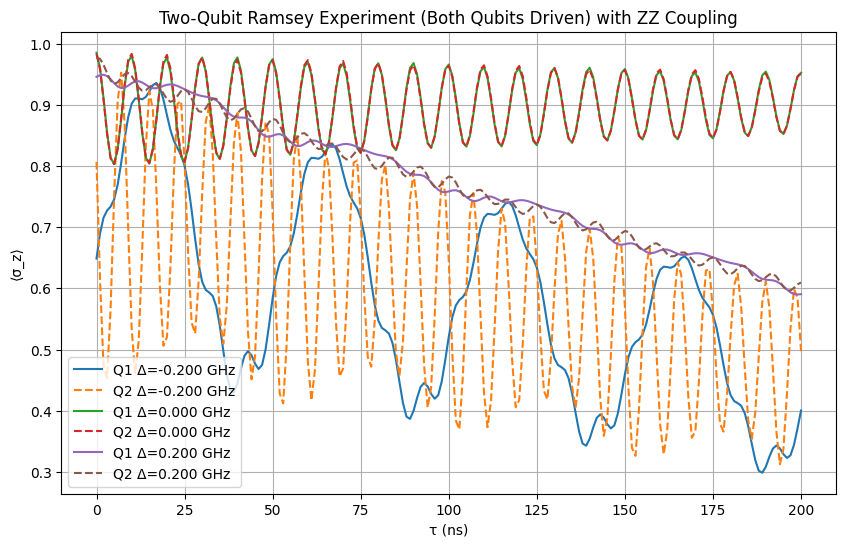

In [4]:
import numpy as np
import qutip as qt

# Two-qubit parameters
w_q1 = 2 * np.pi * 1.0    # Qubit 1 frequency (GHz)
w_q2 = 2 * np.pi * 1.1    # Qubit 2 frequency (GHz)
omega1 = 2 * np.pi * 0.05 # Qubit 1 drive amplitude
omega2 = 2 * np.pi * 0.05 # Qubit 2 drive amplitude
T1, T2 = 1e3, 1e3         # decoherence times
Jz = 2 * np.pi * 0.01     # ZZ coupling strength

# Operators
I = qt.qeye(2)
sx1 = qt.tensor(qt.sigmax(), I)
sx2 = qt.tensor(I, qt.sigmax())
sz1 = qt.tensor(qt.sigmaz(), I)
sz2 = qt.tensor(I, qt.sigmaz())
sm1 = qt.tensor(qt.sigmam(), I)
sm2 = qt.tensor(I, qt.sigmam())

opts = qt.Options(nsteps=1000000)

# Bare Hamiltonian with ZZ coupling
H0 = 0.5 * w_q1 * sz1 + 0.5 * w_q2 * sz2 + Jz * sz1 * sz2

# Build propagator for one H(t) = H0 + Ω cos(ω_d t) σx pulse on both qubits
def pulse_propagator_2q(w_d1, omega1, w_d2, omega2, t_pulse):
    H = [
        H0,
        [sx1, lambda t, args: 2 * omega1 * np.cos(w_d1 * t)],
        [sx2, lambda t, args: 2 * omega2 * np.cos(w_d2 * t)]
    ]
    return qt.propagator(H, t_pulse)

# Ramsey expectation value for both qubits driven
def ramsey_expectation_2q_both(tau, w_d1, w_d2, t_pulse):
    # Collapse operators (T1 and T2 for both qubits)
    c_ops = []
    if T1 > 0:
        c_ops.append(np.sqrt(1/T1) * sm1)
        c_ops.append(np.sqrt(1/T1) * sm2)
    if T2 > 0:
        c_ops.append(np.sqrt(1/(2*T2)) * sz1)
        c_ops.append(np.sqrt(1/(2*T2)) * sz2)

    psi0 = qt.tensor(qt.basis(2, 0), qt.basis(2, 0))

    # First π/2 pulse on both qubits
    H1 = [
        H0,
        [sx1, lambda t, args: 2 * omega1 * np.cos(w_d1 * t)],
        [sx2, lambda t, args: 2 * omega2 * np.cos(w_d2 * t)]
    ]
    res1 = qt.mesolve(H1, psi0, [0, t_pulse], c_ops, [], options=opts)
    psi1 = res1.states[-1]

    # Free evolution (no drive)
    res2 = qt.mesolve(H0, psi1, [0, tau], c_ops, [], options=opts)
    psi2 = res2.states[-1]

    # Second π/2 pulse on both qubits
    H2 = [
        H0,
        [sx1, lambda t, args: 2 * omega1 * np.cos(w_d1 * t)],
        [sx2, lambda t, args: 2 * omega2 * np.cos(w_d2 * t)]
    ]
    res3 = qt.mesolve(H2, psi2, [0, t_pulse], c_ops, [], options=opts)
    psi_final = res3.states[-1]

    # Measure ⟨sz1⟩ and ⟨sz2⟩
    return qt.expect(sz1, psi_final), qt.expect(sz2, psi_final)

# Example sweep: drive both qubits with same detuning
taus      = np.linspace(0, 200, 201)
detunings = np.linspace(-0.2, +0.2, 3) * 2 * np.pi
t_p = np.pi / (2 * omega1)

data1 = {}
data2 = {}
for delta in detunings:
    w_d1 = w_q1 + delta
    w_d2 = w_q2 + delta  # You can set different detunings if desired
    vals1 = []
    vals2 = []
    for tau in taus:
        sz1_val, sz2_val = ramsey_expectation_2q_both(tau, w_d1, w_d2, t_p)
        vals1.append(sz1_val)
        vals2.append(sz2_val)
    data1[delta] = vals1
    data2[delta] = vals2

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for delta in data1:
    plt.plot(taus, data1[delta], label=f"Q1 Δ={delta/(2*np.pi):.3f} GHz")
    plt.plot(taus, data2[delta], '--', label=f"Q2 Δ={delta/(2*np.pi):.3f} GHz")
plt.xlabel("τ (ns)")
plt.ylabel("⟨σ_z⟩")
plt.title("Two-Qubit Ramsey Experiment (Both Qubits Driven) with ZZ Coupling")
plt.legend()
plt.grid(True)
plt.show()

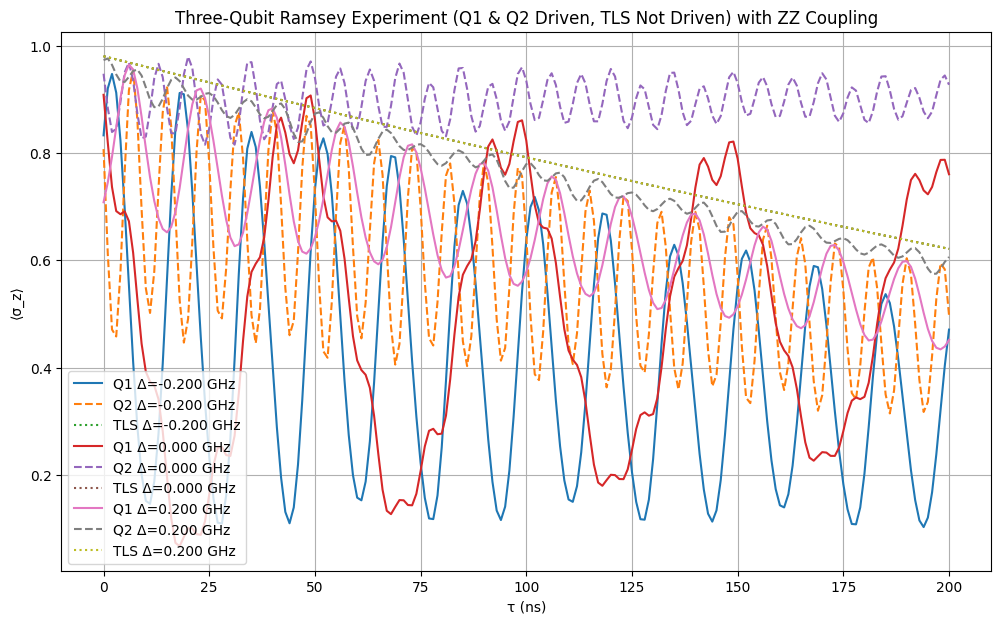

In [5]:
import numpy as np
import qutip as qt

# Three-qubit parameters
w_q1 = 2 * np.pi * 1.0    # Qubit 1 frequency (GHz)
w_q2 = 2 * np.pi * 1.1    # Qubit 2 frequency (GHz)
w_tls = 2 * np.pi * 1.2   # TLS frequency (GHz)
omega1 = 2 * np.pi * 0.05 # Qubit 1 drive amplitude
omega2 = 2 * np.pi * 0.05 # Qubit 2 drive amplitude
T1, T2 = 1e3, 1e3         # decoherence times
T1_tls, T2_tls = 1e3, 1e3 # TLS decoherence times
Jz = 2 * np.pi * 0.01     # ZZ coupling strength (Q1-Q2)
J_tls = 2 * np.pi * 0.02  # Q1-TLS coupling (ZZ)

# Operators
I = qt.qeye(2)
sx1 = qt.tensor(qt.sigmax(), I, I)
sx2 = qt.tensor(I, qt.sigmax(), I)
sz1 = qt.tensor(qt.sigmaz(), I, I)
sz2 = qt.tensor(I, qt.sigmaz(), I)
sz_tls = qt.tensor(I, I, qt.sigmaz())
sm1 = qt.tensor(qt.sigmam(), I, I)
sm2 = qt.tensor(I, qt.sigmam(), I)
sm_tls = qt.tensor(I, I, qt.sigmam())

opts = qt.Options(nsteps=1000000)

# Bare Hamiltonian with ZZ coupling and TLS
H0 = (
    0.5 * w_q1 * sz1 +
    0.5 * w_q2 * sz2 +
    0.5 * w_tls * sz_tls +
    Jz * sz1 * sz2 +
    J_tls * sz1 * sz_tls
)

# Ramsey expectation value for both qubits driven, TLS not driven
def ramsey_expectation_3q_both(tau, w_d1, w_d2, t_pulse):
    # Collapse operators (T1 and T2 for all three qubits)
    c_ops = []
    if T1 > 0:
        c_ops.append(np.sqrt(1/T1) * sm1)
        c_ops.append(np.sqrt(1/T1) * sm2)
    if T2 > 0:
        c_ops.append(np.sqrt(1/(2*T2)) * sz1)
        c_ops.append(np.sqrt(1/(2*T2)) * sz2)
    if T1_tls > 0:
        c_ops.append(np.sqrt(1/T1_tls) * sm_tls)
    if T2_tls > 0:
        c_ops.append(np.sqrt(1/(2*T2_tls)) * sz_tls)

    psi0 = qt.tensor(qt.basis(2, 0), qt.basis(2, 0), qt.basis(2, 0))

    # First π/2 pulse on both qubits (TLS not driven)
    H1 = [
        H0,
        [sx1, lambda t, args: 2 * omega1 * np.cos(w_d1 * t)],
        [sx2, lambda t, args: 2 * omega2 * np.cos(w_d2 * t)]
    ]
    res1 = qt.mesolve(H1, psi0, [0, t_pulse], c_ops, [], options=opts)
    psi1 = res1.states[-1]

    # Free evolution (no drive)
    res2 = qt.mesolve(H0, psi1, [0, tau], c_ops, [], options=opts)
    psi2 = res2.states[-1]

    # Second π/2 pulse on both qubits (TLS not driven)
    H2 = [
        H0,
        [sx1, lambda t, args: 2 * omega1 * np.cos(w_d1 * t)],
        [sx2, lambda t, args: 2 * omega2 * np.cos(w_d2 * t)]
    ]
    res3 = qt.mesolve(H2, psi2, [0, t_pulse], c_ops, [], options=opts)
    psi_final = res3.states[-1]

    # Measure ⟨sz1⟩, ⟨sz2⟩, ⟨sz_tls⟩
    return qt.expect(sz1, psi_final), qt.expect(sz2, psi_final), qt.expect(sz_tls, psi_final)

# Example sweep: drive both qubits with same detuning, TLS not driven
taus      = np.linspace(0, 200, 201)
detunings = np.linspace(-0.2, +0.2, 3) * 2 * np.pi
t_p = np.pi / (2 * omega1)

data1 = {}
data2 = {}
data_tls = {}
for delta in detunings:
    w_d1 = w_q1 + delta
    w_d2 = w_q2 + delta  # You can set different detunings if desired
    vals1 = []
    vals2 = []
    vals_tls = []
    for tau in taus:
        sz1_val, sz2_val, sz_tls_val = ramsey_expectation_3q_both(tau, w_d1, w_d2, t_p)
        vals1.append(sz1_val)
        vals2.append(sz2_val)
        vals_tls.append(sz_tls_val)
    data1[delta] = vals1
    data2[delta] = vals2
    data_tls[delta] = vals_tls

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
for delta in data1:
    plt.plot(taus, data1[delta], label=f"Q1 Δ={delta/(2*np.pi):.3f} GHz")
    plt.plot(taus, data2[delta], '--', label=f"Q2 Δ={delta/(2*np.pi):.3f} GHz")
    plt.plot(taus, data_tls[delta], ':', label=f"TLS Δ={delta/(2*np.pi):.3f} GHz")
plt.xlabel("τ (ns)")
plt.ylabel("⟨σ_z⟩")
plt.title("Three-Qubit Ramsey Experiment (Q1 & Q2 Driven, TLS Not Driven) with ZZ Coupling")
plt.legend()
plt.grid(True)
plt.show()